In [1]:
import numpy as np
import pyspark
from pyspark.context import SparkContext
from pyspark.mllib.regression import LabeledPoint
sc = SparkContext('local', 'test')

23/05/15 00:58:49 WARN Utils: Your hostname, Hays-MacBook.local resolves to a loopback address: 127.0.0.1; using 192.168.0.100 instead (on interface en0)
23/05/15 00:58:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/15 00:58:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/Users/LuMiNaE/Library/Python/3.7/lib/python/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
data = sc.textFile('./data/WildBlueberryPollinationSimulationData.csv')
header = data.first() #extract header
data = data.filter(lambda row: row != header)

In [3]:
print(data.take(1)[0])

len(data.take(1)[0].split(","))

print(data.take(1)[0].split(",")[18-1])
print(data.take(1)[0].split(",")[1:18-1])

0,37.5,0.75,0.25,0.25,0.25,86,52,71.9,62,30,50.8,16,0.26,0.410652063,0.408159008,31.67889844,3813.165795
3813.165795
['37.5', '0.75', '0.25', '0.25', '0.25', '86', '52', '71.9', '62', '30', '50.8', '16', '0.26', '0.410652063', '0.408159008', '31.67889844']


In [4]:
def parsePoint(line):
    string = line.split(",")
    return LabeledPoint(string[len(string)-1], string[1:len(string)-1])

parsedData = data.map(parsePoint)

In [5]:
weights = [.8, .1, .1]
seed = 42
TrainData, ValData, TestData = parsedData.randomSplit(weights, seed)
TrainData.cache()
ValData.cache()
TestData.cache()
nTrain = TrainData.count()
nVal = ValData.count()
nTest = TestData.count()

print(nTrain, nVal, nTest, nTrain + nVal + nTest)
print(data.count())

620 77 80 777
777


In [6]:
TrainData.collect()[0]

LabeledPoint(3813.165795, [37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652063,0.408159008,31.67889844])

In [7]:
def squaredError(label, prediction):
    return (float(label)-float(prediction))**2

def calcRMSE(labelsAndPreds):
    se = labelsAndPreds.map(lambda x: squaredError(x[0], x[1])).collect()
    return np.sqrt(np.mean(se))

In [8]:
averageLabel = TrainData.map(lambda x: x.label).mean()
print(averageLabel)

labelsAndPredsTrain = TrainData.map(lambda x: (x.label, averageLabel))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = ValData.map(lambda x: (x.label, averageLabel))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = TestData.map(lambda x: (x.label, averageLabel))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

6023.576023548384
Baseline Train RMSE = 1370.861
Baseline Validation RMSE = 1309.523
Baseline Test RMSE = 1283.430


(Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Actual'))

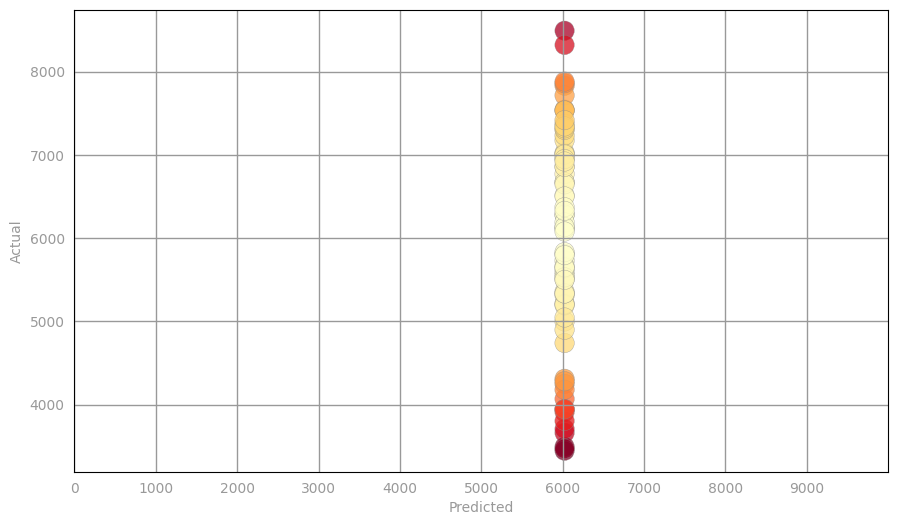

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax


actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda lp: averageLabel) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda lp: (lp.label, averageLabel)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 10000, 1000), np.arange(0, 10000, 1000))
ax.set_xlim(0, 10000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

In [10]:
def gradientSummand(weights, lp):
    return (weights.dot(lp.features) - lp.label) * lp.features

In [11]:
def getLabeledPrediction(weights, observation):
    return (observation.label, weights.dot(observation.features))

In [12]:
def linregGradientDescent(trainData, numIters, alpha):
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda lp: getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda lp: gradientSummand(w, lp))

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient.sum()
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc \
                .parallelize(TrainData.take(exampleN)) \
                .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print(exampleData.take(2))

exampleNumIters = 10
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters, 0.001)
print(exampleWeights)
print(exampleErrorTrain)

[LabeledPoint(3813.165795, [37.5,0.75,0.25]), LabeledPoint(4947.605663, [37.5,0.75,0.25])]
[97.26518669  1.94530373  0.64843458]
[3731.47534085 1677.09019487  779.95012441  779.91341258  779.91218927
  779.91208753  779.91207425  779.91207195  779.91207147  779.91207136]


In [69]:
numItersArray = [100, 250, 500, 1000]
alphaArray = [5e-4, 6e-4, 7e-4]

for alpha in alphaArray:
    for numIters in numItersArray:
        print(str(alpha)+"\t"+str(numIters))

        weightsLR0, errorTrainLR0 = linregGradientDescent(TrainData, numIters, alpha)

        labelsAndPreds = TrainData.map(lambda x: getLabeledPrediction(weightsLR0, x))
        rmseTrainLR0 = calcRMSE(labelsAndPreds)

        labelsAndPreds = ValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
        rmseValLR0 = calcRMSE(labelsAndPreds)

        print('Train LR0 = {0:.3f}\tValidation LR0 = {1:.3f}'.format(rmseTrainLR0, rmseValLR0))

0.0005	100
Train LR0 = 1042.305	Validation LR0 = 1083.286
0.0005	250
Train LR0 = 859.187	Validation LR0 = 905.704
0.0005	500
Train LR0 = 708.785	Validation LR0 = 753.056
0.0005	1000
Train LR0 = 557.894	Validation LR0 = 593.645
0.0006	100
Train LR0 = 3793866.443	Validation LR0 = 3880244.624
0.0006	250
Train LR0 = 620.461	Validation LR0 = 649.826
0.0006	500
Train LR0 = 503.578	Validation LR0 = 530.525
0.0006	1000
Train LR0 = 399.470	Validation LR0 = 418.819
0.0007	100
Train LR0 = 90297138169999163392.000	Validation LR0 = 92355344740088987648.000
0.0007	250
Train LR0 = 101413676.992	Validation LR0 = 141462104.102
0.0007	500
Train LR0 = 76425391.602	Validation LR0 = 117607002.021
0.0007	1000
Train LR0 = 54613003.067	Validation LR0 = 97752859.342


In [70]:
weightsLR0, errorTrainLR0 = linregGradientDescent(TrainData, 1000, 6e-4)

labelsAndPreds = TrainData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseTrainLR0 = calcRMSE(labelsAndPreds)

labelsAndPreds = ValData.map(lambda x: getLabeledPrediction(weightsLR0, x))
rmseValLR0 = calcRMSE(labelsAndPreds)

print('Train RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseTrainBase, rmseTrainLR0))
print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase, rmseValLR0))

Train RMSE:
	Baseline = 1370.861
	LR0 = 399.470
Validation RMSE:
	Baseline = 1309.523
	LR0 = 418.819


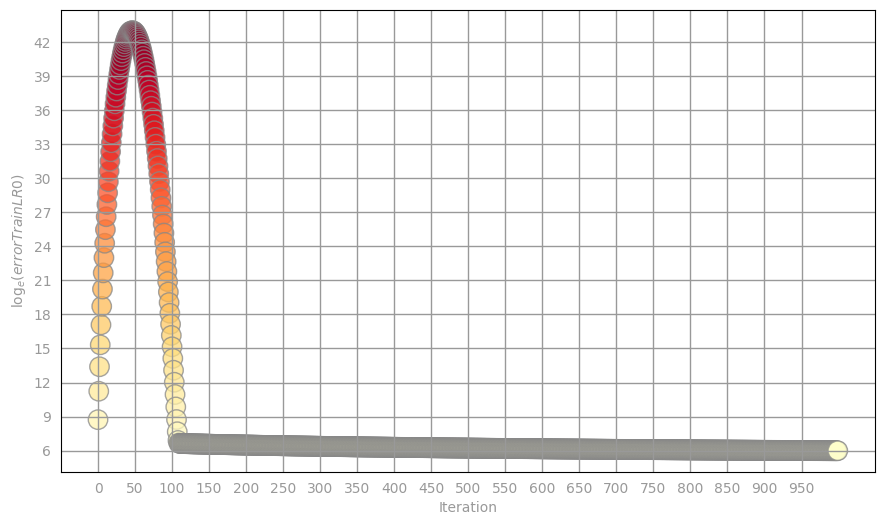

In [71]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 50), np.arange(0, 1000, 3))
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

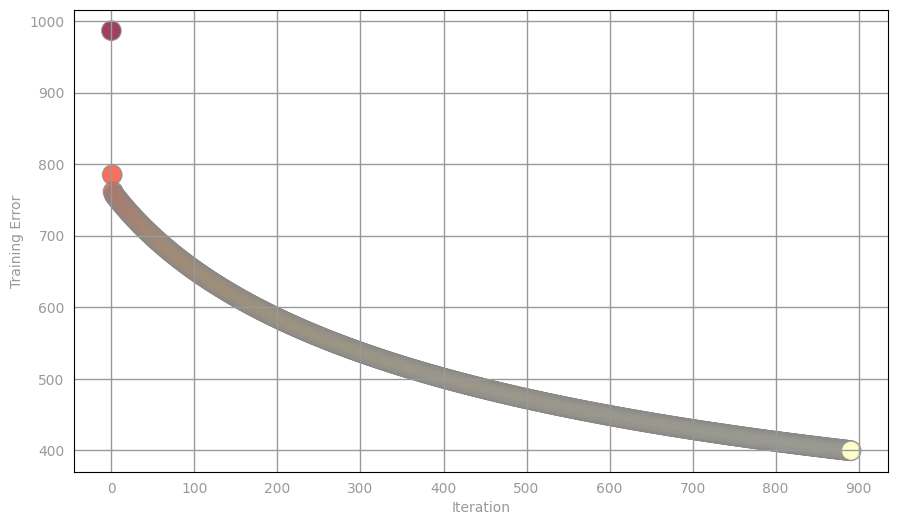

In [77]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[108:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 1000, 100), np.arange(0, 2000, 100))
plt.scatter(range(0, numIters-108), errorTrainLR0[108:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

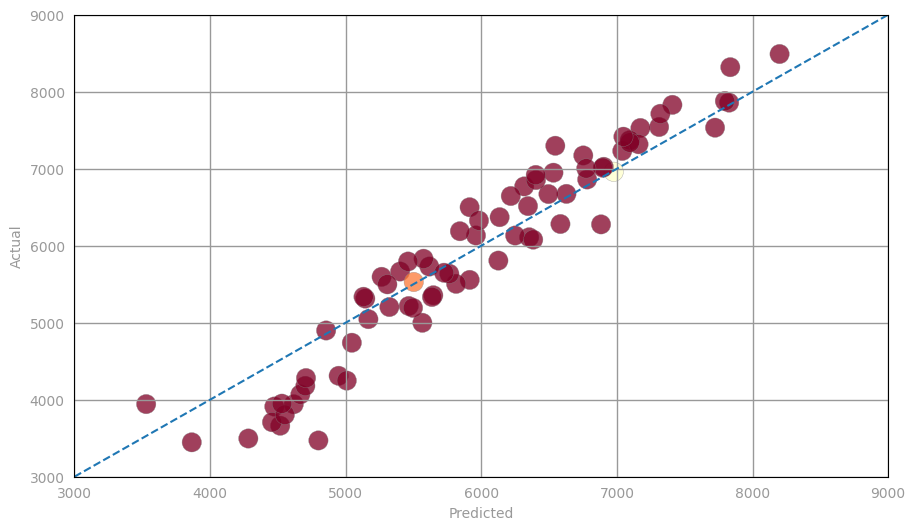

In [78]:
actual = np.asarray(ValData \
                    .map(lambda lp: lp.label) \
                    .collect())

predictions = np.asarray(ValData \
                        .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                        .map(lambda lp: lp[1]) \
                        .collect())

error = np.asarray(ValData \
                    .map(lambda x: getLabeledPrediction(weightsLR0, x)) \
                    .map(lambda lp_tuple: squaredError(lp_tuple[0], lp_tuple[1])) \
                    .collect())

clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 10000, 1000), np.arange(0, 10000, 1000))
ax.set_xlim(3000, 9000)
ax.set_ylim(3000, 9000)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

x_vals = np.array(ax.get_xlim())
y_vals = 1 * x_vals
plt.plot(x_vals, y_vals, '--')